# Image Denoising

## Why Image Denoising?

1. **Images are measurements, not truth**
    
    A digital image is a sampled, quantized measurement of a physical signal (light). Noise is inevitable due to:
    
    - Photon statistics (shot noise)
    - Sensor electronics (thermal/read noise)
    - Transmission and compression artifacts
2. **Noise is information-destroying but statistically structured**
    
    Noise is not arbitrary. It follows distributions (Gaussian, Poisson, impulse, etc.).
    
3. **Denoising is an inverse problem**
    
    You observe:
    
    
    y = x + n
    
    
    where:
    
    - (x): unknown clean image
    - (n): noise
    - (y): observed image
    
    Recovering (x) from (y) is ill-posed: many (x) could explain the same (y).
    
4. **Perfect denoising is impossible**
    
    Removing noise always risks removing signal. Denoising is a **trade-off** between fidelity and smoothness.

## Core Assumptions (That Most Methods Rely On)

Every denoising method assumes **structure in clean images**:

- Neighboring pixels are correlated
- Natural images are locally smooth
- Patches repeat across an image
- Clean images lie on a low-dimensional manifold

Noise, by contrast, is assumed to be:

- Random
- High-frequency
- Less correlated

All denoising is exploiting this asymmetry.

In [ ]:
# install the required libraries

!pip install opencv-python numpy matplotlib pandas

### Task 0: Load an understand a grayscale image

An image is not a picture, It is a 2D matrix of intensity values.

**Why Grayscale?**
we remove color to:
- eliminate channel interactions
- focus purely on intenstiy statistics
- simply noise modeling

Denoising logic does not change fundamentally for color images.

In [ ]:
# import the libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# load theimage
img = cv2.imread("dog_input.jpeg", cv2.IMREAD_GRAYSCALE)

if img is None:
  raise ValueError("Image not found or path incorrect")

In [ ]:
# inspect the image as data

print("Shape: ", img.shape)
print("Data type: ", img.dtype)
print("Min intensity: ", img.min())
print("Max intensity: ", img.max())

Shape:  (183, 275)
Data type:  uint8
Min intensity:  0
Max intensity:  255


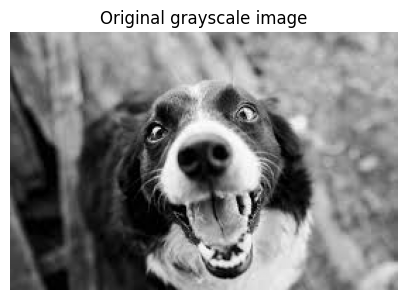

In [ ]:
# visualise the image

plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
plt.title("Original grayscale image")
plt.axis("off")
plt.show()

## Before adding noise, ask:
1. Where are edges?
- the dog image has curved edges, based on its body shape. I guess it could be easily distinguished based on the variations in the pixel intensity.

2. Where are smooth regions?
- The body part of the dog looks quite smoothened.

3. Where are textures?
- The hair, tounge, and eye has its own specific textures.


Noise will hide edges, distort textures, and flatten smooth regions.

## Task 1: Artificially introduce noise

Noise is random error added to a measurement.

### Task 1.1. Gaussian Noise

Gaussian noise assumes:
- Errors are independent
- Errors are zero-mean
- Errors follow a normal distribution

This assumption arises from the Central Limit Theorem: many small independent physical effects sum to a Gaussian.

In [ ]:
# generate gaussian noise
mean = 0
std = 20 # noise strength

noise = np.random.normal(mean, std, img.shape)

# img.shape ensures one noise value per pixel
# noise is continuous, not integer

In [ ]:
# inspect noise statistically

print("Noise mean: ", noise.mean())
print("Noise std: ", noise.std())

Noise mean:  0.10140544471245894
Noise std:  20.060377106576567


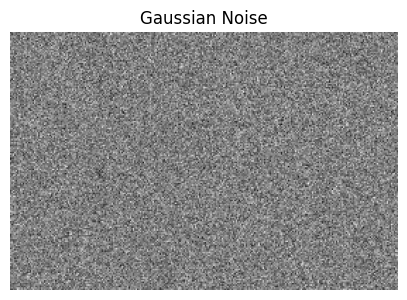

In [ ]:
# visualize the noise

plt.figure(figsize=(5, 5))
plt.imshow(noise, cmap="gray")
plt.title("Gaussian Noise")
plt.axis("off")
plt.show()

In [ ]:
# add the noise to the image

noisy_gaussian = img.astype(np.float32) + noise

# we use float to avoid underflow/overflow during addition

In [ ]:
# clip and convert (limit to the range)

noisy_gaussian = np.clip(noisy_gaussian, 0, 255)
noisy_gaussian = noisy_gaussian.astype(np.uint8)

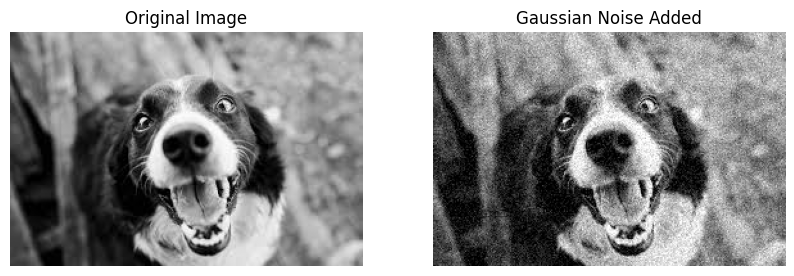

In [ ]:
# visualise original vs noisy

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_gaussian, cmap='gray')
plt.title("Gaussian Noise Added")
plt.axis('off')

plt.show()

**Inference**:
- edges looks grainy
- smooth regions are corrupted
- noise is spatially uniform

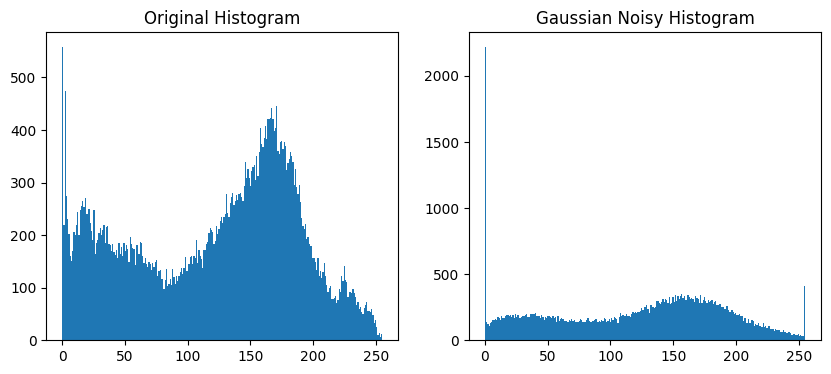

In [ ]:
# histogram perspective

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(img.flatten(), bins=256)
plt.title("Original Histogram")

plt.subplot(1, 2, 2)
plt.hist(noisy_gaussian.flatten(), bins=256)
plt.title("Gaussian Noisy Histogram")

plt.show()

### Task 1.2. Salt-and-Pepper Noise

In gaussian noise
- small deviations
- affects all pixels
- zero-mean, continuous

But, some pixels can be completely wrong, not slightly wrong.

This occurs due to:
- bit errors in transmission
- faulty sensor elements
- dead or hot pixels

This is called as **impulse noise**

**Salt-and-pepper noise:**
- randomly selects pixels
- replaces them with extreme values (0 - pepper, 1 - salt)


Here,
- noise is sparse
- noise is non-additive
- noise is non-gaussian

**Why gaussian filter fails?**
The averaging assumes
- errors are small
- errors cancel out
Impulse noise violates both.

A single corrupted pixel can dominate an average.

In [ ]:
# proabability mask

prob = 0.05     # 5% pixels corrupted

rnd = np.random.rand(*img.shape)

In [ ]:
# create the noise

noisy_sp = img.copy()

noisy_sp[rnd < prob/2] = 0
noisy_sp[rnd > 1 - prob/2] = 255

# replacement instead of addition

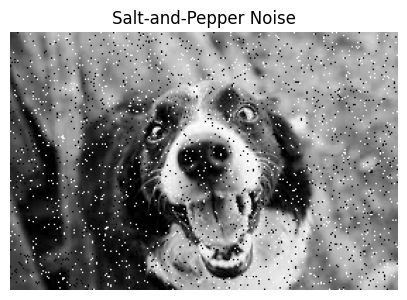

In [ ]:
# visualise the noisy image

plt.figure(figsize=(5, 5))
plt.imshow(noisy_sp, cmap='gray')
plt.title("Salt-and-Pepper Noise")
plt.axis('off')
plt.show()

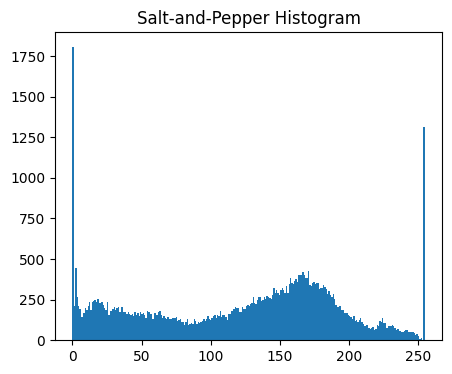

In [ ]:
# visualise as histogram

plt.figure(figsize=(5, 4))
plt.hist(noisy_sp.flatten(), bins=256)
plt.title("Salt-and-Pepper Histogram")
plt.show()

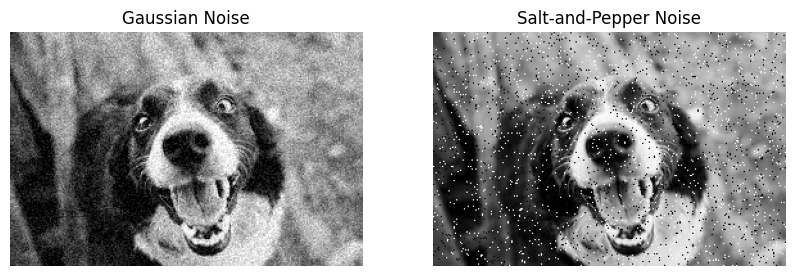

In [ ]:
# compare with gaussian noise

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(noisy_gaussian, cmap='gray')
plt.title("Gaussian Noise")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_sp, cmap='gray')
plt.title("Salt-and-Pepper Noise")
plt.axis('off')

plt.show()

## Task 1.3. Rayleigh Noise

Consider
- radar
- ultrasound
- laser-based imaging
- envelope-detected signals

Here, noise arrises from the magnitude of two orthogonal random components. That magnitude cannot be negative.


In [ ]:
# rayleigh noise generation

scale = 20
noise_rayleigh = np.random.rayleigh(scale, img.shape)

In [ ]:
# understand the distribution

print("Min noise:", noise_rayleigh.min())
print("Mean noise:", noise_rayleigh.mean())
print("Max noise:", noise_rayleigh.max())

Min noise: 0.11380812836534318
Mean noise: 25.088893115009427
Max noise: 103.68633909083113


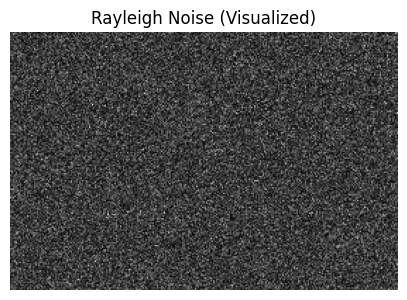

In [ ]:
# visualise the noise

plt.figure(figsize=(5, 5))
plt.imshow(noise_rayleigh, cmap='gray')
plt.title("Rayleigh Noise (Visualized)")
plt.axis('off')
plt.show()

In [ ]:
# corrupt the image with noise

noisy_rayleigh = img.astype(np.float32) + noise_rayleigh

noisy_rayleigh = np.clip(noisy_rayleigh, 0, 255).astype(np.uint8)

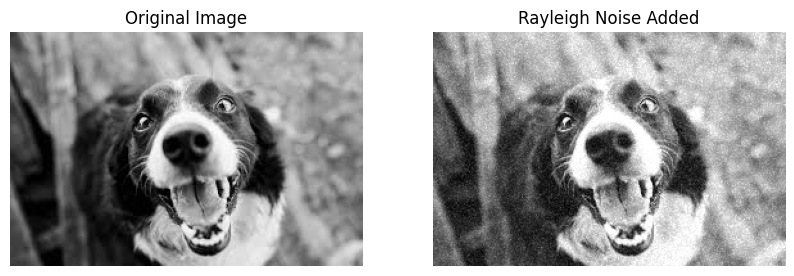

In [ ]:
# visualise the comparison

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_rayleigh, cmap='gray')
plt.title("Rayleigh Noise Added")
plt.axis('off')

plt.show()

**Inference:**
- image looks washed out.
- bright regions saturate.
- contrast reduces.

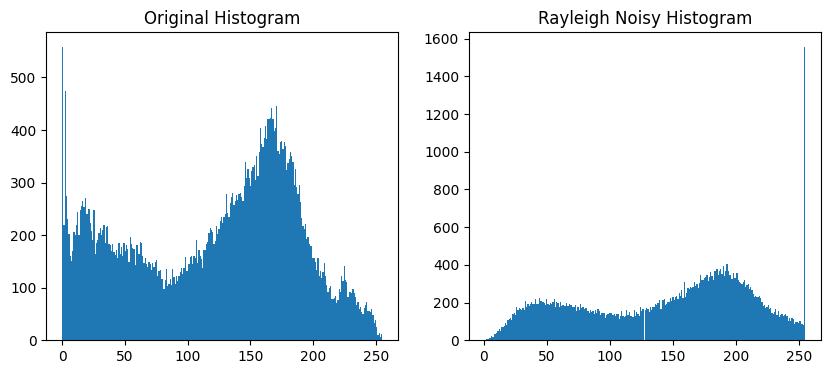

In [ ]:
# histogram analysis

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(img.flatten(), bins=256)
plt.title("Original Histogram")

plt.subplot(1, 2, 2)
plt.hist(noisy_rayleigh.flatten(), bins=256)
plt.title("Rayleigh Noisy Histogram")

plt.show()

### Task 1.4. Erlang (Gamma) Noise

Consider imaging systems where noise arises from:
- multiple independent scattering events
- accumulated random delays or intensities
- photon counting over time

In these cases:
- noise is always positive
- noise strength depends on how many independent events contribute.

This leads to the Gamma family of distributions.

In [ ]:
# noise generation

shape = 2.0
scale = 15.0

noise_gamma = np.random.gamma(shape, scale, img.shape)

In [ ]:
# inspect distribution

print("Min noise:", noise_gamma.min())
print("Mean noise:", noise_gamma.mean())
print("Std noise:", noise_gamma.std())

Min noise: 0.11652581873392388
Mean noise: 30.07024234784408
Std noise: 21.144118148881116


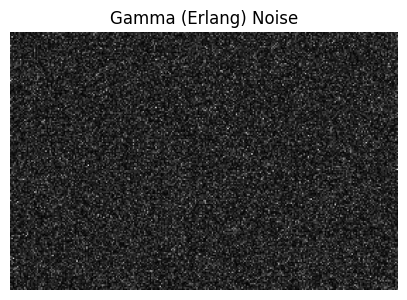

In [ ]:
# visualise noise

plt.figure(figsize=(5, 5))
plt.imshow(noise_gamma, cmap='gray')
plt.title("Gamma (Erlang) Noise")
plt.axis('off')
plt.show()

In [ ]:
# corrupt the image with noise

noisy_gamma = img.astype(np.float32) + noise_gamma
noisy_gamma = np.clip(noisy_gamma, 0, 255).astype(np.uint8)

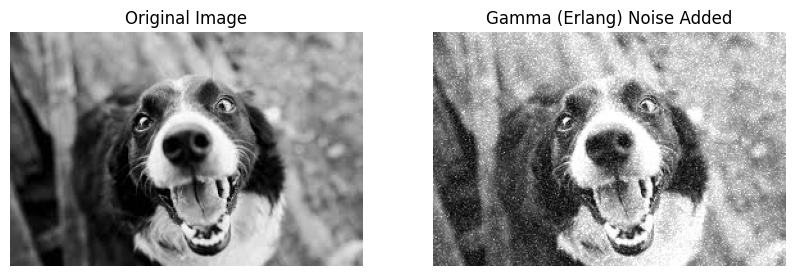

In [ ]:
# visualise the original vs corrupted image

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_gamma, cmap='gray')
plt.title("Gamma (Erlang) Noise Added")
plt.axis('off')

plt.show()

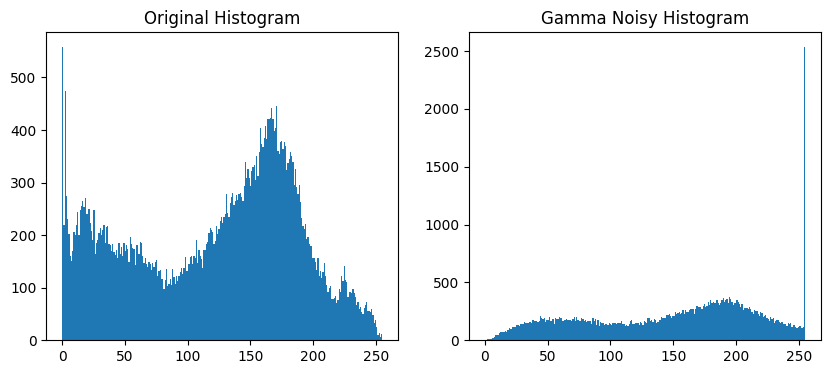

In [ ]:
# histogram analysis

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(img.flatten(), bins=256)
plt.title("Original Histogram")

plt.subplot(1, 2, 2)
plt.hist(noisy_gamma.flatten(), bins=256)
plt.title("Gamma Noisy Histogram")

plt.show()

### Task 1.5.Exponential Noise

when k = 1, it yields exponential noise.

In [ ]:
# noise generation

scale = 15.0

noise_exp = np.random.exponential(scale, img.shape)

In [ ]:
# inspect the noise

print("Min noise:", noise_exp.min())
print("Mean noise:", noise_exp.mean())
print("Std noise:", noise_exp.std())

Min noise: 7.837057105437864e-05
Mean noise: 14.989040742299679
Std noise: 14.93077336754217


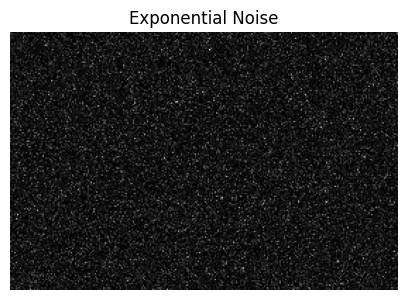

In [ ]:
# visualise noise

plt.figure(figsize=(5, 5))
plt.imshow(noise_exp, cmap='gray')
plt.title("Exponential Noise")
plt.axis('off')
plt.show()

In [ ]:
# add the noise to the image

noisy_exp = img.astype(np.float32) + noise_exp
noisy_exp = np.clip(noisy_exp, 0, 255).astype(np.uint8)

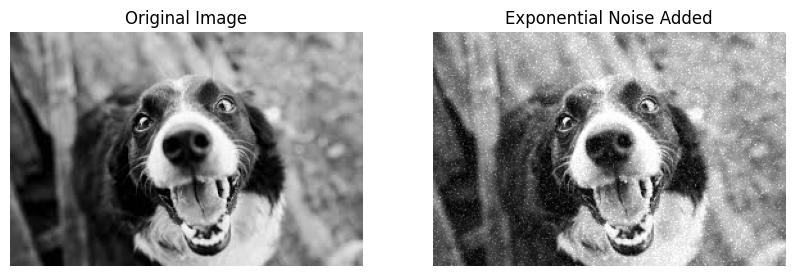

In [ ]:
# visualise the corruption

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_exp, cmap='gray')
plt.title("Exponential Noise Added")
plt.axis('off')

plt.show()

- significant loss of contrast
- bright regions flatten
- image appears washed out

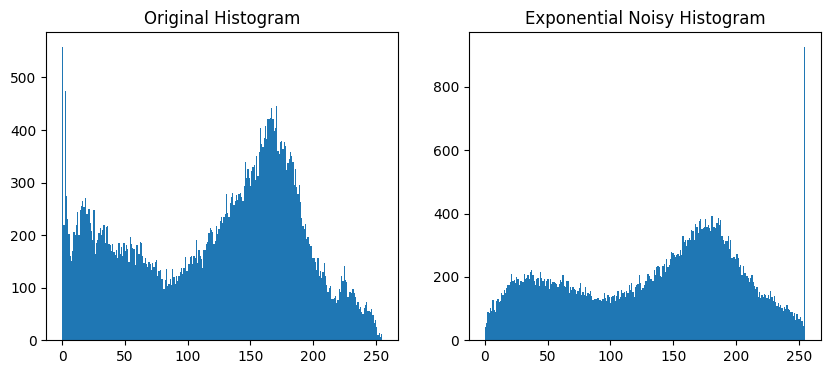

In [ ]:
# histogram analysis

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(img.flatten(), bins=256)
plt.title("Original Histogram")

plt.subplot(1, 2, 2)
plt.hist(noisy_exp.flatten(), bins=256)
plt.title("Exponential Noisy Histogram")

plt.show()

### Task 1.6. Uniform Noise

Uniform noise models:
- Quantization error
- Round-off noise
- Low-precision acquisition
- Communication truncation

Error is equally likely anywhere within a fixed bound. There are no tails and no bias.

In [ ]:
low = -20
high = 20

noise_uniform = np.random.uniform(low, high, img.shape)

In [ ]:
# inspect the distribution

print("Min noise:", noise_uniform.min())
print("Mean noise:", noise_uniform.mean())
print("Max noise:", noise_uniform.max())

Min noise: -19.999912476662583
Mean noise: 0.04224345416584319
Max noise: 19.998839287395427


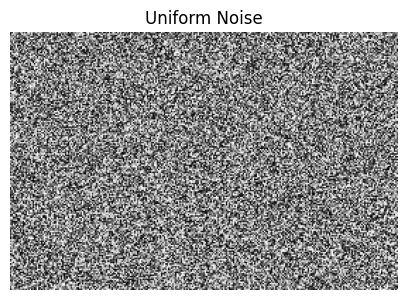

In [ ]:
# visualise the noise

plt.figure(figsize=(5, 5))
plt.imshow(noise_uniform, cmap='gray')
plt.title("Uniform Noise")
plt.axis('off')
plt.show()

In [ ]:
# add the noise to the image

noisy_uniform = img.astype(np.float32) + noise_uniform
noisy_uniform = np.clip(noisy_uniform, 0, 255).astype(np.uint8)

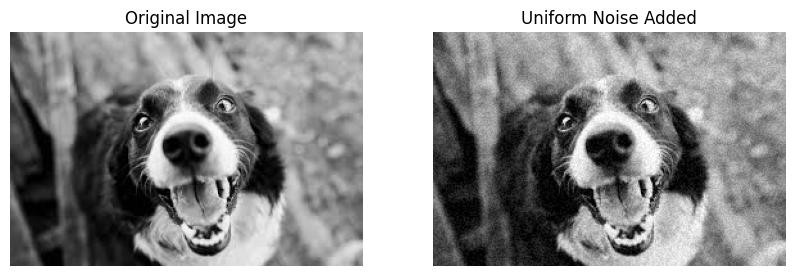

In [ ]:
# comparison

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_uniform, cmap='gray')
plt.title("Uniform Noise Added")
plt.axis('off')

plt.show()

- image is grainy
- contrast is largely preserved.
- no saturation or spikes

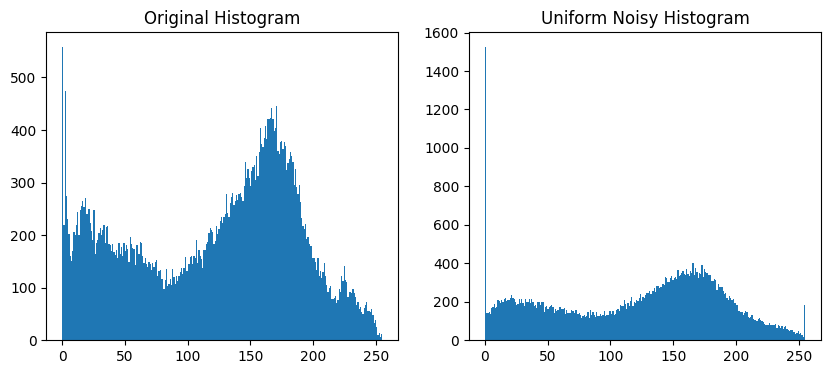

In [ ]:
# histogram analysis

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(img.flatten(), bins=256)
plt.title("Original Histogram")

plt.subplot(1, 2, 2)
plt.hist(noisy_uniform.flatten(), bins=256)
plt.title("Uniform Noisy Histogram")

plt.show()

## Task 2: Denoising Filters

### Task 2.1. Mean (Averaging) Filter

We try to estimate an unknown value x from noisy observations.

y = x + n

In [ ]:
# implement mean filter

def mean_filter(img, k=3):
  kernel = np.ones((k,k), dtype=np.float32) / (k * k)
  return cv2.filter2D(img, -1, kernel)

#### A. Gaussian noise

In [ ]:
mean_gaussian = mean_filter(noisy_gaussian, k=3)

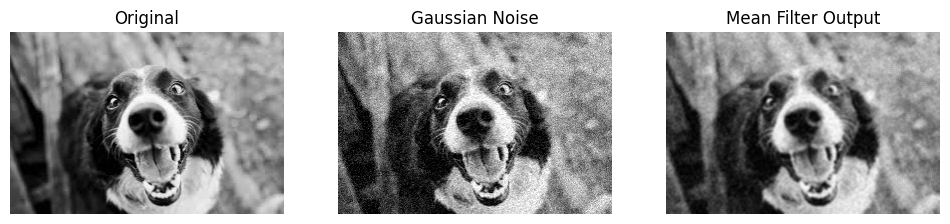

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_gaussian, cmap='gray')
plt.title("Gaussian Noise")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mean_gaussian, cmap='gray')
plt.title("Mean Filter Output")
plt.axis('off')

plt.show()

#### B. Salt-and-Pepper Noise

In [ ]:
mean_sp = mean_filter(noisy_sp, k=3)

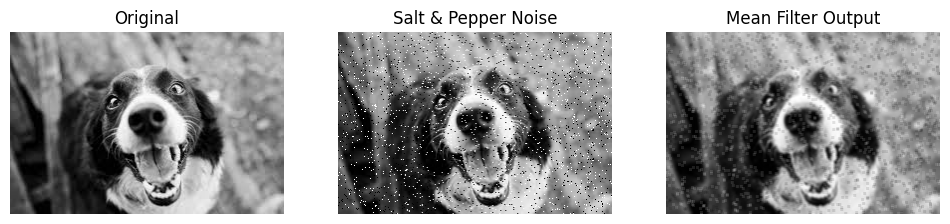

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_sp, cmap='gray')
plt.title("Salt & Pepper Noise")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mean_sp, cmap='gray')
plt.title("Mean Filter Output")
plt.axis('off')

plt.show()

#### C. Rayleigh, Gamma, Uniform Noise

In [ ]:
mean_rayleigh = mean_filter(noisy_rayleigh)
mean_gamma = mean_filter(noisy_gamma)
mean_uniform = mean_filter(noisy_uniform)

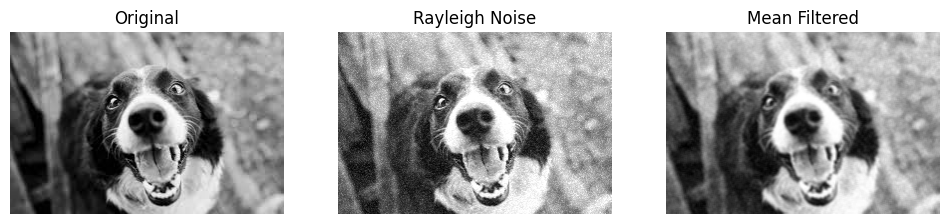

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_rayleigh, cmap='gray')
plt.title("Rayleigh Noise")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mean_rayleigh, cmap='gray')
plt.title("Mean Filtered")
plt.axis('off')

plt.show()

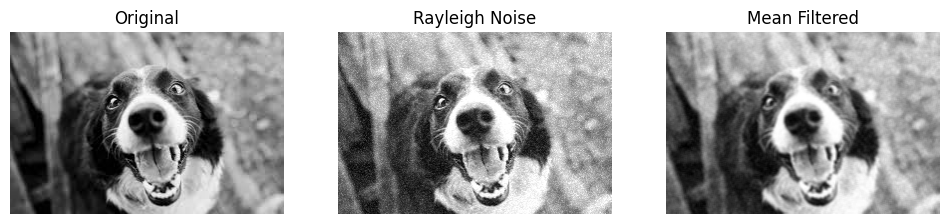

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_rayleigh, cmap='gray')
plt.title("Rayleigh Noise")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mean_rayleigh, cmap='gray')
plt.title("Mean Filtered")
plt.axis('off')

plt.show()

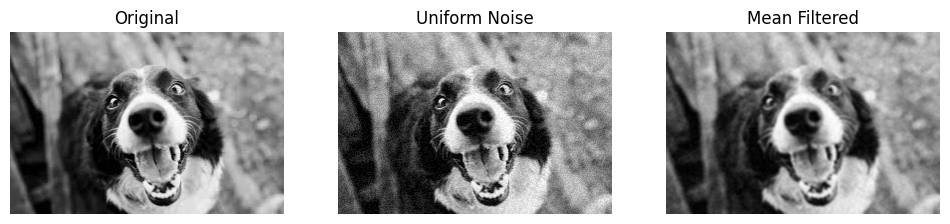

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_uniform, cmap='gray')
plt.title("Uniform Noise")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mean_uniform, cmap='gray')
plt.title("Mean Filtered")
plt.axis('off')

plt.show()

### Task 2.2. Median Filter

In [ ]:
# median filter

def median_filter(img, k=3):
  return cv2.medianBlur(img, k)

#### A. Salt-and-pepper noise

In [ ]:
# apply filter

median_sp = median_filter(noisy_sp, k=3)

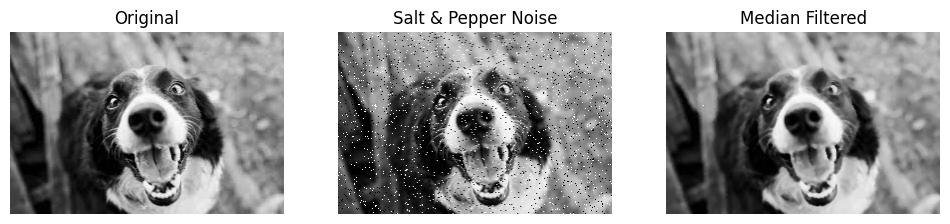

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_sp, cmap='gray')
plt.title("Salt & Pepper Noise")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(median_sp, cmap='gray')
plt.title("Median Filtered")
plt.axis('off')

plt.show()

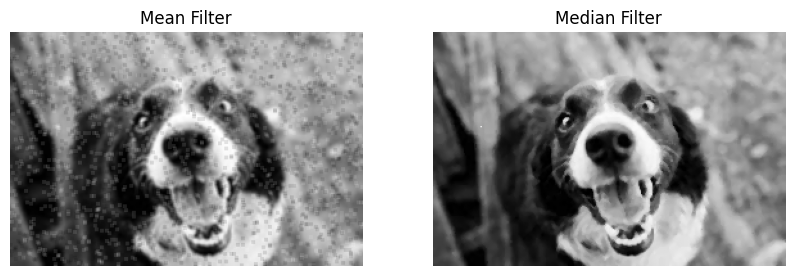

In [ ]:
# mean vs median noise

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(mean_sp, cmap='gray')
plt.title("Mean Filter")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(median_sp, cmap='gray')
plt.title("Median Filter")
plt.axis('off')

plt.show()

#### B. Gaussian Noise

In [ ]:
median_gaussian = median_filter(noisy_gaussian, k=3)

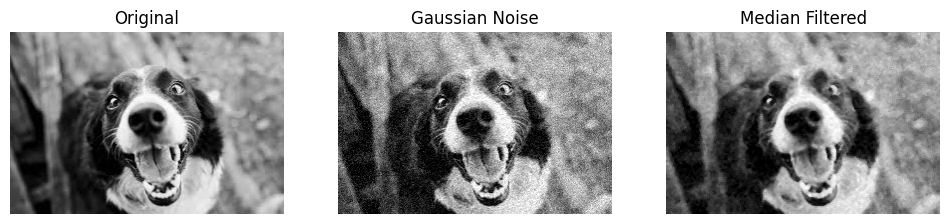

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_gaussian, cmap='gray')
plt.title("Gaussian Noise")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(median_gaussian, cmap='gray')
plt.title("Median Filtered")
plt.axis('off')

plt.show()

#### C. Rayleigh, Gamma, Uniform

In [ ]:
median_rayleigh = median_filter(noisy_rayleigh)
median_gamma = median_filter(noisy_gamma)
median_uniform = median_filter(noisy_uniform)

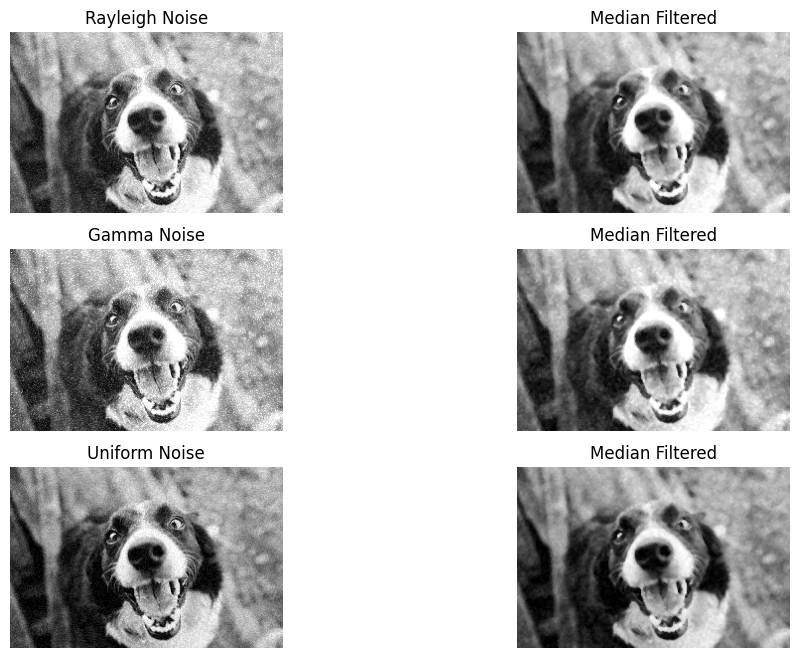

In [ ]:
titles = ["Rayleigh", "Gamma", "Uniform"]
noisy_imgs = [noisy_rayleigh, noisy_gamma, noisy_uniform]
median_imgs = [median_rayleigh, median_gamma, median_uniform]

plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 2, 2*i+1)
    plt.imshow(noisy_imgs[i], cmap='gray')
    plt.title(f"{titles[i]} Noise")
    plt.axis('off')

    plt.subplot(3, 2, 2*i+2)
    plt.imshow(median_imgs[i], cmap='gray')
    plt.title("Median Filtered")
    plt.axis('off')

plt.show()

### Task 2.3. Gaussian Filter

In [ ]:
def gaussian_filter(img, k=5, sigma=1.0):
    return cv2.GaussianBlur(img, (k, k), sigma)

#### A. Gaussian noise

In [ ]:
gauss_gaussian = gaussian_filter(noisy_gaussian, k=5, sigma=1.0)

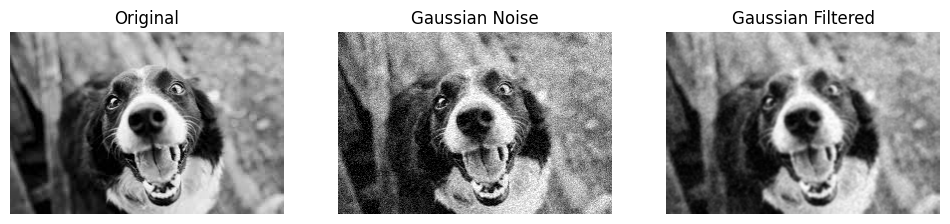

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_gaussian, cmap='gray')
plt.title("Gaussian Noise")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gauss_gaussian, cmap='gray')
plt.title("Gaussian Filtered")
plt.axis('off')

plt.show()

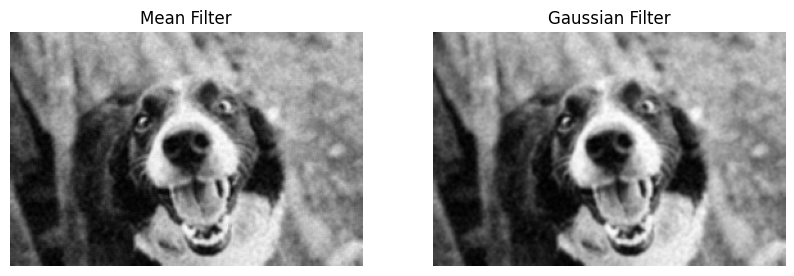

In [ ]:
# gaussian filter vs mean filter

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(mean_gaussian, cmap='gray')
plt.title("Mean Filter")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gauss_gaussian, cmap='gray')
plt.title("Gaussian Filter")
plt.axis('off')

plt.show()

#### B. Rayleigh Noise

In [ ]:
gauss_rayleigh = gaussian_filter(noisy_rayleigh, k=5, sigma=1.0)

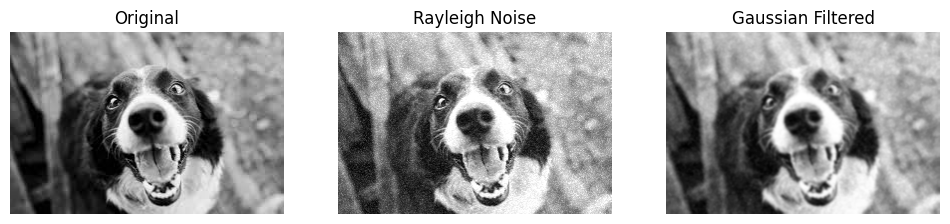

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_rayleigh, cmap='gray')
plt.title("Rayleigh Noise")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gauss_rayleigh, cmap='gray')
plt.title("Gaussian Filtered")
plt.axis('off')

plt.show()

#### C. Gamma and Exponential Noise

In [ ]:
gauss_gamma = gaussian_filter(noisy_gamma, k=5, sigma=1.0)
gauss_exp = gaussian_filter(noisy_exp, k=5, sigma=1.0)

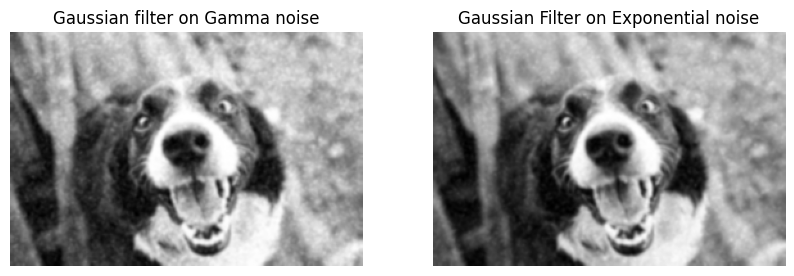

In [ ]:
# gaussian filter on gamma and exponential noise

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(gauss_gamma, cmap='gray')
plt.title("Gaussian filter on Gamma noise")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gauss_exp, cmap='gray')
plt.title("Gaussian Filter on Exponential noise")
plt.axis('off')

plt.show()

#### D. Uniform noise

In [ ]:
gauss_uniform = gaussian_filter(noisy_uniform, k=5, sigma=1.0)

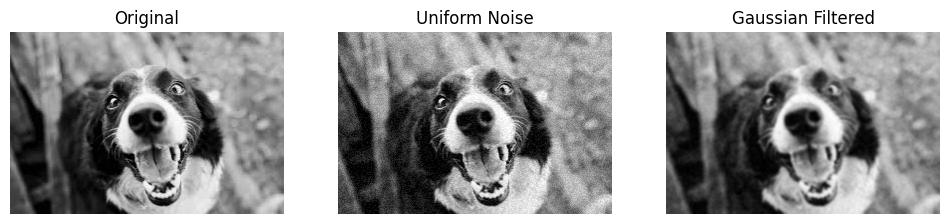

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_uniform, cmap='gray')
plt.title("Uniform Noise")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gauss_uniform, cmap='gray')
plt.title("Gaussian Filtered")
plt.axis('off')

plt.show()

## Task 3. Evaluation

**What are we measuring?**

The distance between original image and restored image.

# 1. Mean Squared Error (MSE)

## Step 1 — Definition

For an original image (I) and a restored image (\hat{I}) of size (M \times N):

### Explanation

1. **Pixel-wise difference**: (I_{ij} - \hat{I}_{ij}) measures error at each pixel.
2. **Square the difference**:

   * Penalizes large deviations more than small ones (L2 norm)
   * Prevents negative and positive errors from canceling out
3. **Average over all pixels**: Gives a single scalar value summarizing total reconstruction error.

---

## Step 2 — Interpretation

* **MSE = 0** → perfect reconstruction
* **Higher MSE** → worse reconstruction

**Units**: squared pixel intensity (e.g., if image is 0–255, units are intensity²)

**Example**:

* Gaussian noise added: MSE increases slightly
* Salt-and-pepper noise: MSE can spike due to extreme pixel deviations

---

## Step 3 — Limitations of MSE

1. **Not perceptually aligned**

   * Two images with same MSE may look different to human eyes
2. **Sensitive to outliers**

   * Impulse noise can dominate the metric
3. **Global metric only**

   * Doesn’t differentiate between errors at edges or smooth regions

---

# 2. Peak Signal-to-Noise Ratio (PSNR)

## Step 1 — Definition

PSNR is a **logarithmic scale version of MSE**:


---

## Step 2 — Intuition

* Converts squared error to **log scale**, making it easier to interpret large ranges
* Higher PSNR → closer to original image
* Rough guidelines for 8-bit images:

  * PSNR > 40 dB → almost imperceptible difference
  * PSNR 30–40 dB → good quality
  * PSNR < 30 dB → noticeable artifacts

---

## Step 3 — Why PSNR is useful

* **Normalized metric**: independent of image scale
* **Comparative metric**: easily compare multiple denoising methods on same image
* Works well when **noise is additive and zero-mean**, especially Gaussian

---

## Step 4 — Limitations of PSNR

1. **Perceptual mismatch**

   * Human vision cares more about edges, textures, contrast than raw pixel differences
2. **Insensitive to structural errors**

   * Slight blurring can reduce PSNR moderately but look poor visually
3. **Sensitive to scaling/clipping**

   * Saturated regions may distort PSNR values

---

# 3. Connection Between MSE and PSNR

* **PSNR is a logarithmic transformation of MSE**

* MSE gives **direct squared error**, PSNR gives **relative signal strength vs noise**

* Think of MSE as the **raw distance**, PSNR as the **signal quality in dB**, which is more intuitive for engineers.

---

# 4. Practical Usage in Denoising

* **Gaussian noise** → PSNR correlates well with perceived quality
* **Impulse noise** → MSE and PSNR may understate the effect of isolated bright/dark pixels
* **Highly biased noise (Rayleigh, Gamma, Exponential)** → PSNR still useful, but **visual inspection is important**

---

# 5. Optional Extensions

* **SSIM (Structural Similarity Index)**

  * Measures perceived structural fidelity
  * Compliments PSNR/MSE
* **Peak Absolute Error (PAE)**

  * Shows worst-case pixel deviation

---

**Summary (Bedrock Truths)**:

| Metric | What it measures             | Pros                  | Cons                                  |
| ------ | ---------------------------- | --------------------- | ------------------------------------- |
| MSE    | Average squared pixel error  | Simple, precise       | Sensitive to outliers, not perceptual |
| PSNR   | Ratio of signal max vs noise | Normalized, log scale | Not perceptual, ignores structure     |

---



In [ ]:
import numpy as np

def mse(original, restored):
    return np.mean((original.astype(np.float32) - restored.astype(np.float32)) ** 2)

def psnr(original, restored):
    m = mse(original, restored)
    if m == 0:
        return float('inf')
    return 10 * np.log10((255 ** 2) / m)


In [ ]:
# gaussian noise

results = []

results.append(["Gaussian", "Mean",
                mse(img, mean_gaussian),
                psnr(img, mean_gaussian)])

results.append(["Gaussian", "Median",
                mse(img, median_gaussian),
                psnr(img, median_gaussian)])

results.append(["Gaussian", "Gaussian",
                mse(img, gauss_gaussian),
                psnr(img, gauss_gaussian)])


In [ ]:
# salt-and-pepper noise

results.append(["Salt & Pepper", "Mean",
                mse(img, mean_sp),
                psnr(img, mean_sp)])

results.append(["Salt & Pepper", "Median",
                mse(img, median_sp),
                psnr(img, median_sp)])

results.append(["Salt & Pepper", "Gaussian",
                mse(img, gaussian_filter(noisy_sp)),
                psnr(img, gaussian_filter(noisy_sp))])


In [ ]:
# rayleigh noise

results.append(["Rayleigh", "Mean",
                mse(img, mean_rayleigh),
                psnr(img, mean_rayleigh)])

results.append(["Rayleigh", "Median",
                mse(img, median_rayleigh),
                psnr(img, median_rayleigh)])

results.append(["Rayleigh", "Gaussian",
                mse(img, gauss_rayleigh),
                psnr(img, gauss_rayleigh)])

In [ ]:
# gamma (erlang) noise

results.append(["Gamma", "Mean",
                mse(img, mean_gamma),
                psnr(img, mean_gamma)])

results.append(["Gamma", "Median",
                mse(img, median_gamma),
                psnr(img, median_gamma)])

results.append(["Gamma", "Gaussian",
                mse(img, gauss_gamma),
                psnr(img, gauss_gamma)])

In [ ]:
# uniform noise

results.append(["Uniform", "Mean",
                mse(img, mean_uniform),
                psnr(img, mean_uniform)])

results.append(["Uniform", "Median",
                mse(img, median_uniform),
                psnr(img, median_uniform)])

results.append(["Uniform", "Gaussian",
                mse(img, gauss_uniform),
                psnr(img, gauss_uniform)])


In [ ]:
# create a performance table

import pandas as pd

df = pd.DataFrame(results, columns=["Noise Type", "Filter", "MSE", "PSNR (dB)"])
df


Noise Type    Filter         MSE  PSNR (dB)
0        Gaussian      Mean  107.867538  27.801895
1        Gaussian    Median  122.340729  27.255095
2        Gaussian  Gaussian  100.276741  28.118801
3   Salt & Pepper      Mean  202.258408  25.071737
4   Salt & Pepper    Median   50.272251  31.117519
5   Salt & Pepper  Gaussian  175.685104  25.683453
6        Rayleigh      Mean  669.274109  19.874763
7        Rayleigh    Median  636.080566  20.095682
8        Rayleigh  Gaussian  667.578369  19.885780
9           Gamma      Mean  931.200867  18.440369
10          Gamma    Median  807.545593  19.059134
11          Gamma  Gaussian  923.418274  18.476818
12        Uniform      Mean   76.506943  29.293795
13        Uniform    Median   81.542755  29.016951
14        Uniform      Mean   76.506943  29.293795
15        Uniform    Median   81.542755  29.016951
16        Uniform  Gaussian   75.476639  29.352676

In [ ]:
# best PSNR per noise

best_filters = df.loc[df.groupby("Noise Type")["PSNR (dB)"].idxmax()]
best_filters


Noise Type    Filter         MSE  PSNR (dB)
10          Gamma    Median  807.545593  19.059134
2        Gaussian  Gaussian  100.276741  28.118801
7        Rayleigh    Median  636.080566  20.095682
4   Salt & Pepper    Median   50.272251  31.117519
16        Uniform  Gaussian   75.476639  29.352676

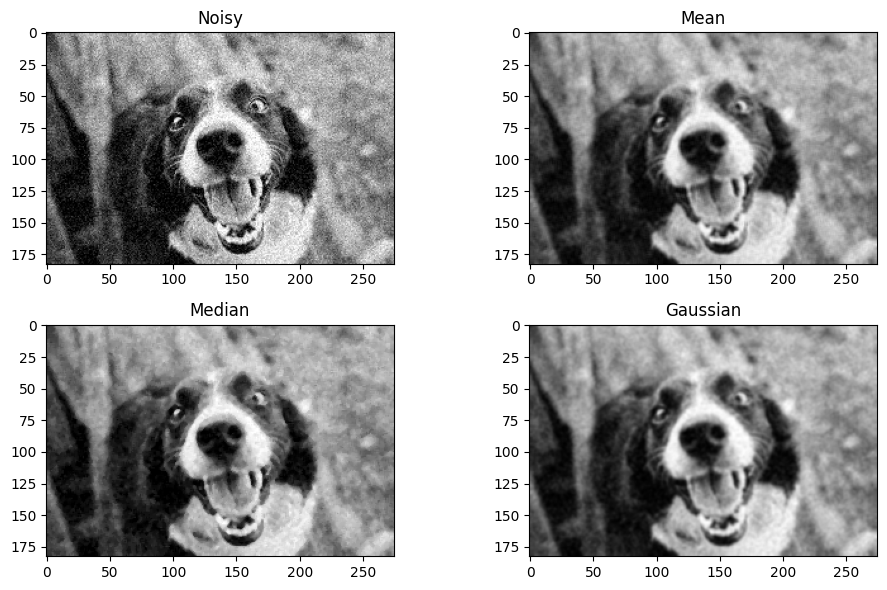

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.imshow(noisy_gaussian, cmap='gray')
plt.title("Noisy")

plt.subplot(2, 2, 2)
plt.imshow(mean_gaussian, cmap='gray')
plt.title("Mean")

plt.subplot(2, 2, 3)
plt.imshow(median_gaussian, cmap='gray')
plt.title("Median")

plt.subplot(2, 2, 4)
plt.imshow(gauss_gaussian, cmap='gray')
plt.title("Gaussian")

plt.tight_layout()
plt.show()